In [17]:
import openai
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [ ]:
# Set OpenAI enviroment
api_key = "XXX"
client = openai.OpenAI(api_key=api_key)

In [ ]:
# Import Shark Tank data
df_lab = pd.read_csv('XXX/sharktanklab_data.csv')
df_products = pd.read_excel('XXXX/sharktank_products.xlsx')

# Clean the product names
df_lab['Product'] = df_lab['Product'].str.strip().str.lower().str.replace(r'\s+', '', regex=True).str.replace(r"[^\w]", "", regex=True)
df_lab['Category'] = df_lab['Category'].apply(lambda x: x.split(';')[0].strip() if isinstance(x, str) else x)
df_products['Product Title'] = df_products['Product Title'].str.strip().str.lower().str.replace(r'\s+', '', regex=True).str.replace(r"[^\w]", "", regex=True)
df_products['Short Description'] = df_products['Short Description'].str.replace(r"PRODUCT SUMMARY", "", regex=True)

# Merge the data frames
merged_df = pd.merge(df_lab, df_products, left_on='Product', right_on='Product Title', how='inner')

# Create new DataFrame with the needed columns
result_df = merged_df[['Product', 'Category', 'Short Description', 'Long Description']]

# Rename columns
result_df.rename(columns={
    'Product': 'product name',
    'Category': 'industry',
    'Short Description': 'short description',
    'Long Description': 'long description'
}, inplace=True)

result_df=result_df.dropna()
print(result_df['industry'].value_counts())


NameError: name 'pd' is not defined

In [4]:
# Define function to get embeddings
def get_openai_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding  # Corrected access path

# Encode industry labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(result_df['industry'])

# Embed short descirptions
business_descriptions = result_df['short description'].tolist()
openai_embeddings = np.array([get_openai_embedding(desc) for desc in business_descriptions], dtype=np.float32)

# Use SMOTE to balance the class weights
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(openai_embeddings, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define Neural Network Model
model = keras.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),  # Increased dropout
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
model.fit(
    X_train, y_train, epochs=50, validation_data=(X_test, y_test),
    batch_size=16, class_weight=class_weight_dict, callbacks=[early_stopping]
)

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Define the function to predict product industry
def predict_industry(description):
    embedding = np.array([get_openai_embedding(description)], dtype=np.float32)
    pred = model.predict(embedding)
    industry = label_encoder.inverse_transform([np.argmax(pred)])[0]
    return industry

/Users/benmischeck/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-14 10:54:24.712347: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-14 10:54:24.712510: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-14 10:54:24.713382: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1744620864.713965 13507228 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744620864.714730 13507228 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 

Epoch 1/50


2025-04-14 10:54:25.834844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2790 - loss: 2.7572 - val_accuracy: 0.7993 - val_loss: 1.2907
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7212 - loss: 1.3184 - val_accuracy: 0.8763 - val_loss: 0.8779
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8681 - loss: 0.9303 - val_accuracy: 0.9114 - val_loss: 0.7498
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8940 - loss: 0.7849 - val_accuracy: 0.9298 - val_loss: 0.6715
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9174 - loss: 0.7163 - val_accuracy: 0.9348 - val_loss: 0.6273
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9243 - loss: 0.6569 - val_accuracy: 0.9365 - val_loss: 0.6178
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9221 - loss: 0.6616 - val_accuracy: 0.9365 - val_loss: 0.6264
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9353 - loss: 0.6004 - val_accuracy: 0.929

In [5]:
# Example Prediction
new_description = "Reusable Packaging Services"
predicted_industry = predict_industry(new_description)
print(f"Predicted Industry: {predicted_industry}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted Industry: Service


In [ ]:
# Import the survey ideas from the pre-cleaned vesion
df_survey_ideas = pd.read_excel("XXXX/SurveyResults_clean.xlsx")

# Select the needed columns
df_survey_ideas = df_survey_ideas[['Response ID', 'GroupAssignment', 'Task1_ChatGPT_Access', 
                    'Task1_ChatGPT_Interaction', 'DAT_score', 'Task1_IdeaGen_Human - Idea 1',
                    'Task1_IdeaGen_Human - Idea 2', 'Task1_IdeaGen_Human - Idea 3',
                    'Task1_IdeaGen_Human - Idea 4', 'Task1_IdeaGen_Human - Idea 5',
                    'Task1_IdeaGen_Human - Idea 6', 'Task1_IdeaGen_Human - Idea 7',
                    'Task1_IdeaGen_Human - Idea 8', 'Task1_IdeaGen_Human - Idea 9',
                    'Task1_IdeaGen_Human - Idea 10','Task1_IdeaGen_HumanAI - Idea 2',
                    'Task1_IdeaGen_HumanAI - Idea 3', 'Task1_IdeaGen_HumanAI - Idea 4',
                    'Task1_IdeaGen_HumanAI - Idea 5', 'Task1_IdeaGen_HumanAI - Idea 6',
                    'Task1_IdeaGen_HumanAI - Idea 7', 'Task1_IdeaGen_HumanAI - Idea 8',
                    'Task1_IdeaGen_HumanAI - Idea 9', 'Task1_IdeaGen_HumanAI - Idea 10']]

# Display the survey ideas
display(df_survey_ideas)

,Response ID,GroupAssignment,Task1_ChatGPT_Access,Task1_ChatGPT_Interaction,DAT_score,Task1_IdeaGen_Human - Idea 1,Task1_IdeaGen_Human - Idea 2,Task1_IdeaGen_Human - Idea 3,Task1_IdeaGen_Human - Idea 4,Task1_IdeaGen_Human - Idea 5,...,Task1_IdeaGen_Human - Idea 10,Task1_IdeaGen_HumanAI - Idea 2,Task1_IdeaGen_HumanAI - Idea 3,Task1_IdeaGen_HumanAI - Idea 4,Task1_IdeaGen_HumanAI - Idea 5,Task1_IdeaGen_HumanAI - Idea 6,Task1_IdeaGen_HumanAI - Idea 7,Task1_IdeaGen_HumanAI - Idea 8,Task1_IdeaGen_HumanAI - Idea 9,Task1_IdeaGen_HumanAI - Idea 10
0,R_2MeVhGrthluSOHf,Human_Human,0,0,78.535901,Outside showers with solar system,Solar System on Windows,Outlets with an on- off System,Solar powered phone charger,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R_2I6tZ6LTbfYc0GX,Human/AI_Human,1,1,77.496777,NaN,NaN,NaN,NaN,NaN,...,NaN,Zero waste cooking class,Sustainable fashion rental platform,Biodegradable toothbrush,Recycled ocean plastic sneaker,NaN,NaN,NaN,NaN,NaN
2,R_2y8eiKbpPQCPHiI,Human/AI_Human/AI,1,1,78.237401,NaN,NaN,NaN,NaN,NaN,...,NaN,Bamboo toothbrush,Beeswax wraps,Solar-powered chargers,Cloth shopping bags (tote bags),Eco-friendly cleaning supplies,Compost bins,LED light bulbs,Rechargeable batteries,Eco-friendly laundry detergent sheets
3,R_8X68xD9TOB81k0E,Human_Human/AI,0,0,79.926777,Reusable bags,Ecofriendly phone cases,E cars,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R_8dj9aA2If4L0AXS,Human/AI_Human,1,1,81.771145,NaN,NaN,NaN,NaN,NaN,...,NaN,waste free grocery delivery,electric bike sharing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,R_2VjYLyvWLK2W2c0,Human_Human/AI,0,0,76.631359,CO2 smart tracker app,Recycling home kits,Ocean cleaning robots,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,R_2hXSc7JOdfYXCbF,Human/AI_Human,1,1,75.937733,NaN,NaN,NaN,NaN,NaN,...,NaN,Urban Vertical Farming Kits,Sustainable Clothing Line,Smart Irrigation System,Eco-Friendly Household Cleaning Products,Wearable Air Quality Monitors,Plant-Based Water Filtration System,Electric Bicycle with Regenerative Braking,Home Energy Management System,Solar-Powered Device Chargers
97,R_2X5AcYRStqAdIFr,Human/AI_Human/AI,1,1,77.285641,NaN,NaN,NaN,NaN,NaN,...,NaN,Urban Composting Service,Urban Vertical Farming,Electric Bike Rentals,Plant-Based Meal Kit Delivery,Eco-Friendly Subscription Box,Organic Waste Biogas Production,Sustainable Home Decor,Sustainable Tourism Agency,NaN
98,R_88GoPhwGUi5v6yC,Human_Human,0,0,80.322303,Reusable packaging boxes that can be folded in...,Shoe sole made of old car tires,Modular bed for kids that grow with them,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def reshape_idea_dataframe(df_survey_ideas):
    metadata_cols = ['Response ID', 'GroupAssignment', 'Task1_ChatGPT_Access', 'Task1_ChatGPT_Interaction', 'DAT_score']
    idea_cols = [col for col in df_survey_ideas.columns if 'Idea' in col]

    # create empty object
    long_format_data = []

    # loop through all ideas
    for idx, row in df_survey_ideas.iterrows():
        for col in idea_cols:
            idea_text = row[col]
            if pd.notnull(idea_text):
                if 'HumanAI' in col:
                    source = 'HumanAI'
                else:
                    source = 'Human'
                idea_number = ''.join(filter(str.isdigit, col))  
                long_format_data.append({
                    'ResponseID': row['Response ID'],
                    'GroupAssignment': row['GroupAssignment'],
                    'ChatGPT_Access': row['Task1_ChatGPT_Access'],
                    'ChatGPT_Interaction': row['Task1_ChatGPT_Interaction'],
                    'DAT_score': row['DAT_score'],
                    'IdeaSource': source,
                    'IdeaNumber': int(idea_number) if idea_number else None,
                    'IdeaText': idea_text.strip()
                })

    # store in new dataframe
    long_df = pd.DataFrame(long_format_data)
    return long_df

df_survey_ideas_long = reshape_idea_dataframe(df_survey_ideas)


In [8]:
# Predict industries for participant-generated ideas
df_survey_ideas_long['predicted industry'] = df_survey_ideas_long['IdeaText'].apply(lambda x: predict_industry(x))

display(df_survey_ideas_long)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

,ResponseID,GroupAssignment,ChatGPT_Access,ChatGPT_Interaction,DAT_score,IdeaSource,IdeaNumber,IdeaText,predicted industry
0,R_2MeVhGrthluSOHf,Human_Human,0,0,78.535901,Human,11,Outside showers with solar system,Home & Tools
1,R_2MeVhGrthluSOHf,Human_Human,0,0,78.535901,Human,12,Solar System on Windows,Home & Tools
2,R_2MeVhGrthluSOHf,Human_Human,0,0,78.535901,Human,13,Outlets with an on- off System,Home & Tools
3,R_2MeVhGrthluSOHf,Human_Human,0,0,78.535901,Human,14,Solar powered phone charger,Tech & Electronics
4,R_2I6tZ6LTbfYc0GX,Human/AI_Human,1,1,77.496777,HumanAI,12,Zero waste cooking class,Home & Tools
...,...,...,...,...,...,...,...,...,...
549,R_88GoPhwGUi5v6yC,Human_Human,0,0,80.322303,Human,12,Shoe sole made of old car tires,Clothing & Accessories
550,R_88GoPhwGUi5v6yC,Human_Human,0,0,80.322303,Human,13,Modular bed for kids that grow with them,Kids & Toys
551,R_8JZNn02sl4d54l3,Human_Human/AI,0,0,78.027647,Human,11,Biodegradable cigarettes,Food & Drink
552,R_8JZNn02sl4d54l3,Human_Human/AI,0,0,78.027647,Human,12,Gym equipment that uses produced energy to cha...,Tech & Electronics


In [9]:
df_chatgpt = pd.read_csv("/Users/benmischeck/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master_Uni-Köln/WS2024 Master Thesis/Data Analysis/Data/Raw/chatgpt_survey_responses.csv")

In [10]:
# Define function to explode chatgpt dataframe
def explode_task1_ideas(df):
    rows = []
    for _, row in df.iterrows():
        idea_list = str(row['Task1']).split('\n')  
        for i, idea in enumerate(idea_list, start=1):
            idea = idea.strip()
            if idea: 
                rows.append({
                    'Iteration': row['Iteration'],
                    'IdeaNumber': i,
                    'IdeaText': idea,
                    'IdeaSource': 'AI',

                })
    return pd.DataFrame(rows)

# Apply to the chatgpt dataset
df_chatgpt_long = explode_task1_ideas(df_chatgpt)


In [11]:
# Predict industries for chatgpt-generated ideas
df_chatgpt_long['predicted industry'] = df_chatgpt_long['IdeaText'].apply(lambda x: predict_industry(x))

display(df_chatgpt_long)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

,Iteration,IdeaNumber,IdeaText,IdeaSource,predicted industry
0,1,1,Eco-Commuter App,AI,Apps
1,1,2,Urban Vertical Gardens,AI,Home & Tools
2,1,3,Solar-Powered Smart Benches,AI,Tech & Electronics
3,1,4,Green Delivery Service,AI,Service
4,1,5,Energy-Efficient Home Kits,AI,Home & Tools
...,...,...,...,...,...
495,50,6,Automated Home Energy Monitors,AI,Home & Tools
496,50,7,Community Composting Hubs,AI,Home & Tools
497,50,8,Rainwater Collection Systems,AI,Home & Tools
498,50,9,Solar-Powered Charging Stations,AI,Tech & Electronics


In [12]:
# Combine participant- and chatgpt-generated ideas into one dataframe
df_ideas_1 = df_survey_ideas_long[['IdeaSource', 'IdeaText', 'predicted industry']]
df_ideas_2 = df_chatgpt_long[['IdeaSource', 'IdeaText', 'predicted industry']]
df_ideas = pd.concat([df_ideas_1, df_ideas_2], ignore_index=True)

display(df_ideas)

,IdeaSource,IdeaText,predicted industry
0,Human,Outside showers with solar system,Home & Tools
1,Human,Solar System on Windows,Home & Tools
2,Human,Outlets with an on- off System,Home & Tools
3,Human,Solar powered phone charger,Tech & Electronics
4,HumanAI,Zero waste cooking class,Home & Tools
...,...,...,...
1049,AI,Automated Home Energy Monitors,Home & Tools
1050,AI,Community Composting Hubs,Home & Tools
1051,AI,Rainwater Collection Systems,Home & Tools
1052,AI,Solar-Powered Charging Stations,Tech & Electronics


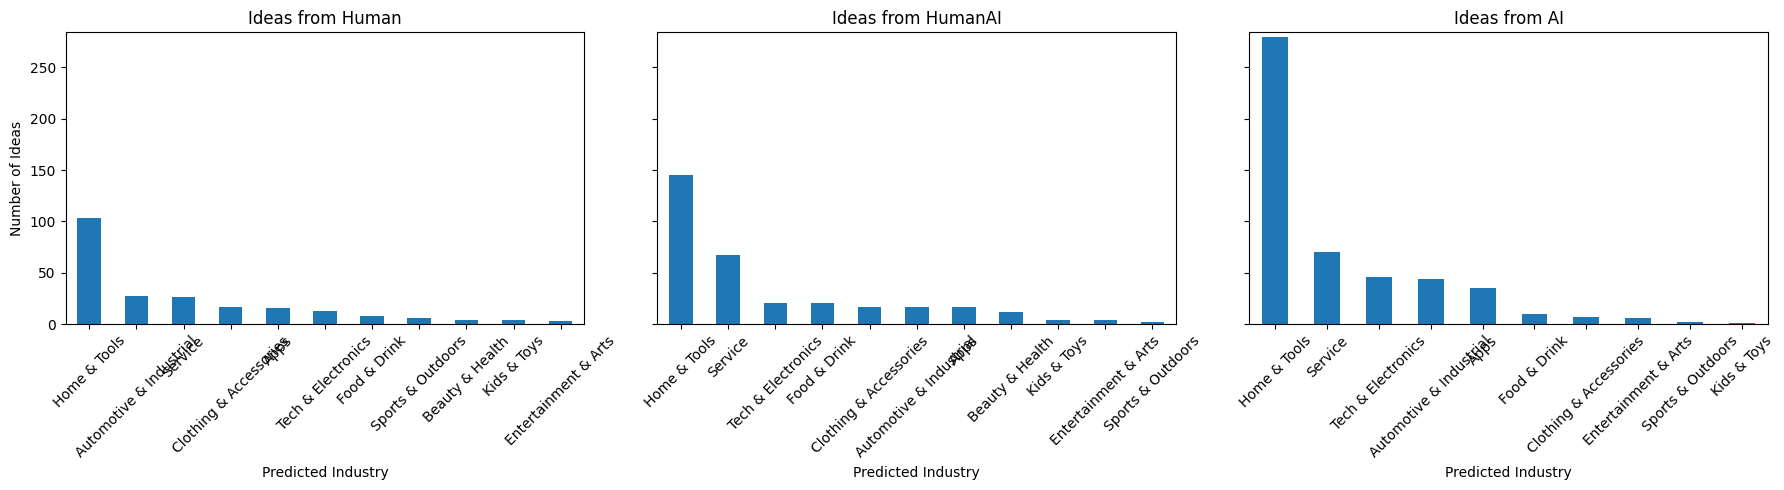

In [21]:
# Get all ideasource variables
idea_sources = df_ideas['IdeaSource'].unique()

# Create subplots for all three plots
n_sources = len(idea_sources)
fig, axes = plt.subplots(1, n_sources, figsize=(6 * n_sources, 5), sharey=True)
max_count = df_ideas.groupby(['IdeaSource', 'predicted industry']).size().groupby('IdeaSource').max().max()

# Generate each subplot
for i, source in enumerate(idea_sources):
    subset = df_ideas[df_ideas['IdeaSource'] == source]
    counts = subset['predicted industry'].value_counts().sort_values(ascending=False)
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Ideas from {source}')
    axes[i].set_xlabel('Predicted Industry')
    axes[i].set_ylabel('Number of Ideas' if i == 0 else '')
    axes[i].set_ylim(0, max_count + 5)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_39783/4128056198.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_39783/4128056198.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_39783/4128056198.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


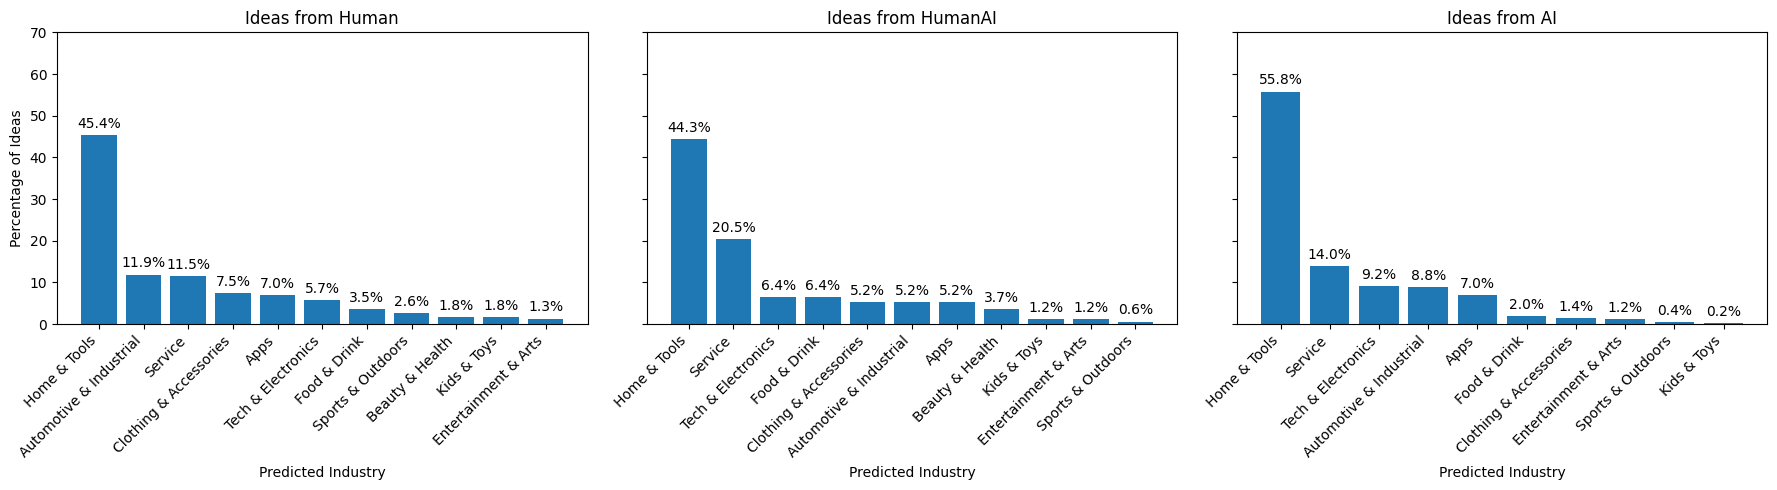

In [32]:
# Get all ideasource variables
idea_sources = df_ideas['IdeaSource'].unique()
n_sources = len(idea_sources)
fig, axes = plt.subplots(1, n_sources, figsize=(6 * n_sources, 5), sharey=True)

# Generate subplots with percentage y-axis and value labels
for i, source in enumerate(idea_sources):
    subset = df_ideas[df_ideas['IdeaSource'] == source]
    counts = subset['predicted industry'].value_counts(normalize=True).sort_values(ascending=False) * 100
    bars = axes[i].bar(counts.index, counts.values)
    axes[i].set_title(f'Ideas from {source}')
    axes[i].set_xlabel('Predicted Industry')
    axes[i].set_ylabel('Percentage of Ideas' if i == 0 else '')
    axes[i].set_ylim(0, 70)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].bar_label(bars, fmt='%.1f%%', padding=3)

    
plt.tight_layout()
plt.show()


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_39783/387077604.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


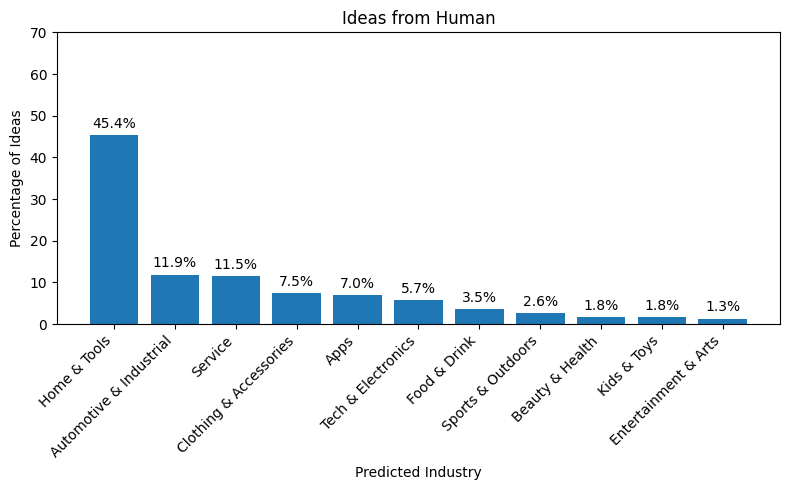

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_39783/387077604.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


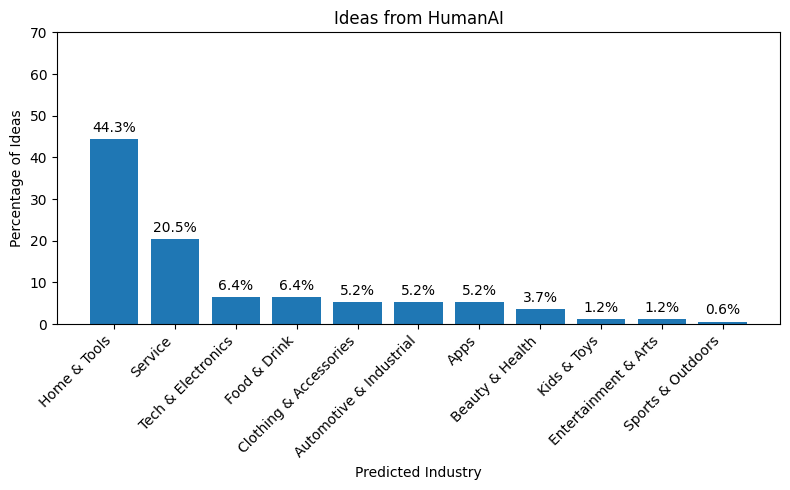

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_39783/387077604.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


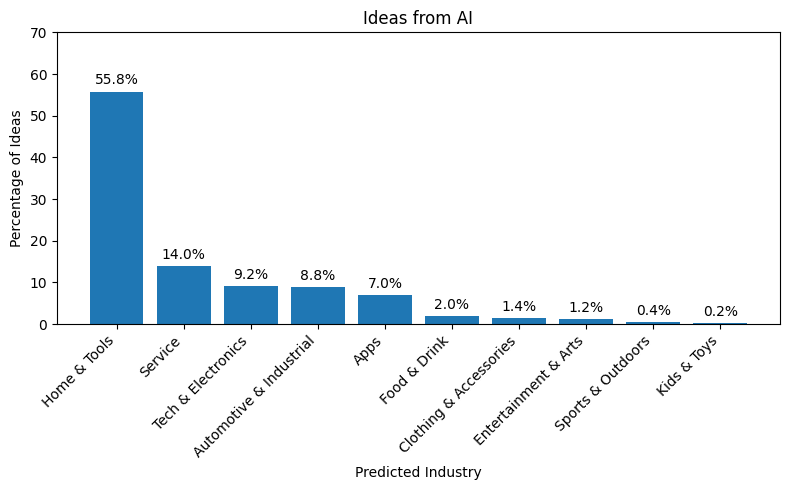

In [33]:
# Get all ideasource variables
idea_sources = df_ideas['IdeaSource'].unique()

# Loop through all three groups to create singular pltos
for source in idea_sources:
    subset = df_ideas[df_ideas['IdeaSource'] == source]
    counts = subset['predicted industry'].value_counts(normalize=True).sort_values(ascending=False) * 100
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(counts.index, counts.values)

    # plot
    ax.set_title(f'Ideas from {source}')
    ax.set_xlabel('Predicted Industry')
    ax.set_ylabel('Percentage of Ideas')
    ax.set_ylim(0, 70)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.bar_label(bars, fmt='%.1f%%', padding=3)

    plt.tight_layout()
    plt.show()


Entropy (diversity) per group:
AI: 1.819 bits
Human: 2.432 bits
HumanAI: 2.345 bits

Chi-square test:
χ² = 97.14, p-value = 0.0000, dof = 20


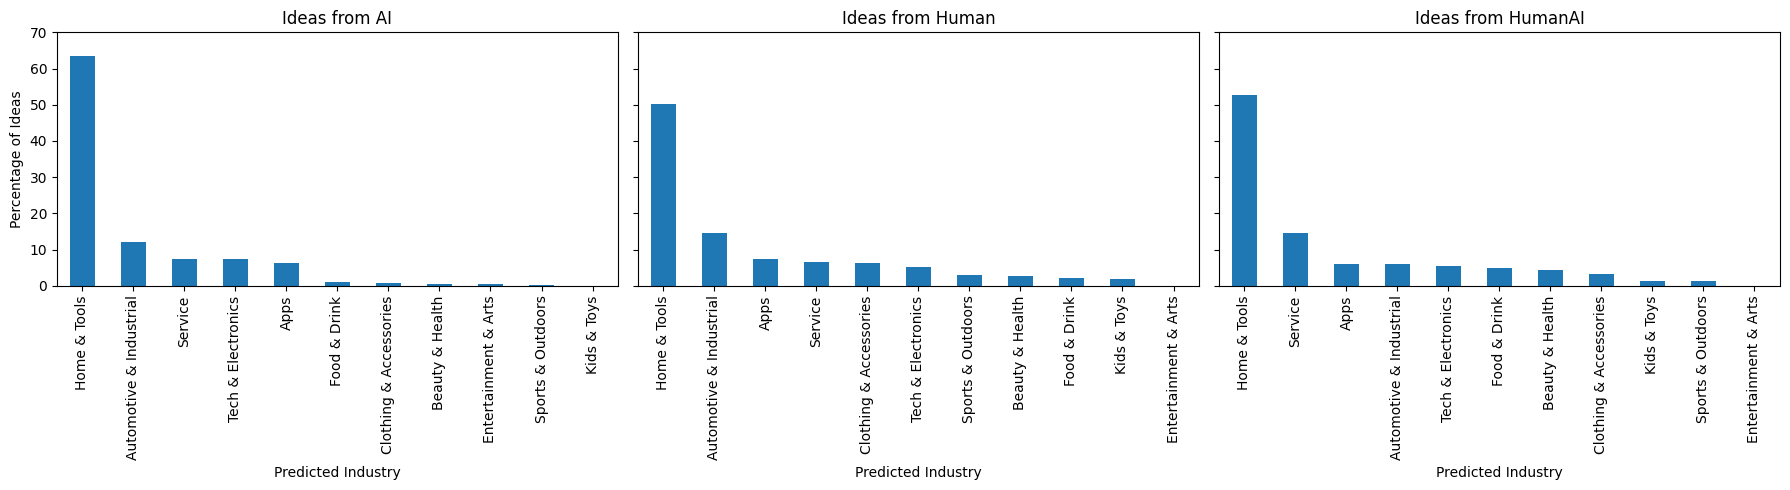

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency

# count ideas per ideasource
industry_counts = df_ideas.groupby(['IdeaSource', 'predicted industry']).size().unstack(fill_value=0)

# Calculate chi2
chi2, p, dof, expected = chi2_contingency(industry_counts.values)
print(f"\nChi-square test:\nχ² = {chi2:.2f}, p-value = {p:.4f}, dof = {dof}")

